In [1]:
import json
import os
import pickle
import warnings

import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import pandas as pd

from utils.data_utils import (DynamicBatchSampler, collate_fn, get_dataset,
                              get_grouping, get_static_dataset,
                              get_test_dataset, get_test_synthetic_dataset)
from utils.optuna_utils import load_best_model
from utils.result_utils import (inference, plot_3d_combined_pdfs, plot_pdf,
                                report_results, generate_smooth_pdf, calculate_crps,
                                calculate_wasserstein, calculate_var_metric,)
from utils.train_utils import ComparisonQuantileLoss, TwoStageQuantileLoss, train
from LinearRegression import LinearQuantileRegression
from wasserstein_min import get_best_hybrid_pdf_params, get_best_lstm_pdf_params

with open("config.json", "r") as f:
    config = json.load(f)

taus = config["general"]["quantiles"]
validation_start_date = config["general"]["dates"]["validation_period"]["start_date"]
validation_end_date = config["general"]["dates"]["validation_period"]["end_date"]
test_start_date = config["general"]["dates"]["test_period"]["start_date"]
test_end_date = config["general"]["dates"]["test_period"]["end_date"]
loss_fn = TwoStageQuantileLoss(taus)
test_loss_fn = ComparisonQuantileLoss(taus)
results = {}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(config["general"]["seed"])

warnings.filterwarnings("ignore")

if not os.path.exists("plots"):
    os.makedirs("plots")

In [2]:
lstm_model, lstm_params = load_best_model('lstm')

lstm_model.to(DEVICE)

lstm_normalization_window = lstm_params['normalazation_window']
lstm_batch_size = lstm_params['batch_size']
l1_reg = lstm_params['l1_reg']
l2_reg = lstm_params['l2_reg']

lstm_optimizer = torch.optim.Adam(lstm_model.parameters(
), lr=lstm_params['learning_rate'], weight_decay=l2_reg)

print(lstm_model)
print(f"Model has {sum(p.numel() for p in lstm_model.parameters() if p.requires_grad)} parameters")

LSTM_Model(
  (normalize_lstm): LSTM(49, 16, batch_first=True, dropout=0.17780297705940562)
  (normalize_module): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.17780297705940562, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.17780297705940562, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ELU(alpha=1.0)
    (8): Dropout(p=0.17780297705940562, inplace=False)
    (9): Linear(in_features=64, out_features=32, bias=True)
    (10): ELU(alpha=1.0)
    (11): Dropout(p=0.17780297705940562, inplace=False)
    (12): Linear(in_features=32, out_features=32, bias=True)
    (13): ELU(alpha=1.0)
    (14): Dropout(p=0.17780297705940562, inplace=False)
    (15): Linear(in_features=32, out_features=37, bias=True)
  )
  (market_lstm): LSTM(21, 16, batch_first=True, dropout=0.17780297705940562)
  (market_module): Sequential(

In [3]:
lstm_params

{'batch_size': 64,
 'learning_rate': 0.0006301914928215536,
 'normalazation_window': 219,
 'raw_lstm_layers': 1,
 'raw_lstm_h': 16,
 'raw_hidden_layers': 5,
 'raw_hidden_layer_0': 128,
 'raw_hidden_layer_1': 64,
 'raw_hidden_layer_2': 64,
 'raw_hidden_layer_3': 32,
 'raw_hidden_layer_4': 32,
 'market_lstm_layers': 1,
 'market_lstm_h': 16,
 'market_hidden_layers': 3,
 'market_hidden_layer_0': 16,
 'market_hidden_layer_1': 16,
 'market_hidden_layer_2': 32,
 'dropout': 0.17780297705940562,
 'market_activation': 'tanh',
 'hidden_activation': 'elu',
 'use_layer_norm': 0,
 'l1_reg': 0.0005907317710879327,
 'l2_reg': 0.0009171456011371559}

In [4]:
if os.path.exists('lstm_model.pth'):
    lstm_model.load_state_dict(torch.load('lstm_model.pth'))
    lstm_model.to(DEVICE)
    print("Model loaded from lstm_model.pth")
else:
    lstm_train_dataset = get_dataset(
        lstm_normalization_window, "1998-01-01", validation_start_date)
    lstm_val_dataset = get_dataset(lstm_normalization_window,
                                   validation_start_date, validation_end_date)
    lstm_train_batch_sampler = DynamicBatchSampler(
        lstm_train_dataset, batch_size=lstm_batch_size)
    lstm_val_batch_sampler = DynamicBatchSampler(lstm_val_dataset, batch_size=lstm_batch_size)

    lstm_train_loader = DataLoader(
        lstm_train_dataset, batch_sampler=lstm_train_batch_sampler, collate_fn=collate_fn)
    lstm_val_loader = DataLoader(
        lstm_val_dataset, batch_sampler=lstm_val_batch_sampler, collate_fn=collate_fn)
    
    _, lstm_model = train(
        model=lstm_model,
        train_loader=lstm_train_loader,
        val_loader=lstm_val_loader,
        criterion=loss_fn,
        optimizer=lstm_optimizer,
        num_epochs=100,
        patience=10,
        l1_reg=l1_reg,
        lstm=False,
        verbose=True
    )
    torch.save(lstm_model.state_dict(), 'lstm_model.pth')

Model loaded from lstm_model.pth


In [5]:
dense_model, dense_params = load_best_model('dense')

dense_model.to(DEVICE)

dense_normalization_window = dense_params['normalazation_window']
dense_batch_size = dense_params['batch_size']
l1_reg = dense_params['l1_reg']
l2_reg = dense_params['l2_reg']

dense_optimizer = torch.optim.Adam(dense_model.parameters(), lr=dense_params['learning_rate'], weight_decay=l2_reg)

print(dense_model)

QuantileDense(
  (raw_layers): ModuleList(
    (0): Linear(in_features=49, out_features=32, bias=True)
    (1): Dropout(p=0.46228174569794733, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): Dropout(p=0.46228174569794733, inplace=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=32, out_features=64, bias=True)
    (7): Dropout(p=0.46228174569794733, inplace=False)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=64, out_features=37, bias=True)
  )
  (raw_model): Sequential(
    (0): Linear(in_features=49, out_features=32, bias=True)
    (1): Dropout(p=0.46228174569794733, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): Dropout(p=0.46228174569794733, inplace=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=32, out_features=64, bias=True)
    (7): Dropout(p=0.4622817456

In [6]:
dense_params

{'batch_size': 32,
 'learning_rate': 0.00026207935278322914,
 'normalazation_window': 207,
 'n_raw_hidden_layers': 3,
 'raw_hidden_layer_0': 32,
 'raw_hidden_layer_1': 32,
 'raw_hidden_layer_2': 64,
 'hidden_activation': 'leaky_relu',
 'n_market_hidden_layers': 1,
 'market_hidden_layer_0': 64,
 'market_activation': 'elu',
 'dropout': 0.46228174569794733,
 'layer_norm': 0,
 'l1_reg': 0.00048765570640181864,
 'l2_reg': 0.00012167657515795093}

In [7]:
if os.path.exists('dense_model.pth'):
    dense_model.load_state_dict(torch.load('dense_model.pth'))
    dense_model.to(DEVICE)
    print("Model loaded from dense_model.pth")
else:
    dense_train_dataset = get_static_dataset(dense_normalization_window, "1998-01-01", validation_start_date)
    dense_val_dataset = get_static_dataset(dense_normalization_window, validation_start_date, validation_end_date)

    dense_train_loader = DataLoader(dense_train_dataset, batch_size=dense_batch_size, shuffle=True)
    dense_val_loader = DataLoader(dense_val_dataset, batch_size=dense_batch_size, shuffle=False)
    _, dense_model = train(
        model=dense_model,
        train_loader=dense_train_loader,
        val_loader=dense_val_loader,
        criterion=loss_fn,
        optimizer=dense_optimizer,
        num_epochs=100,
        patience=10,
        l1_reg=l1_reg,
        verbose=True
    )
    torch.save(dense_model.state_dict(), 'dense_model.pth')

Model loaded from dense_model.pth


In [8]:
if not os.path.exists("quant_reg.pth"):
    dense_train_dataset = get_static_dataset(dense_normalization_window, "1998-01-01", validation_start_date)

    big_X = []
    big_y = []
    for i in range(len(dense_train_dataset)):
        x, _, z, y, _ = dense_train_dataset[i]
        xx = torch.cat((x, z))
        y = y.view(-1).cpu().numpy()
        big_X.append(xx.cpu().numpy())
        big_y.append(y)
    big_X = np.array(big_X)
    big_y = np.array(big_y).reshape(-1)

    quant_reg = LinearQuantileRegression(taus)
    quant_reg.train(big_X, big_y)

    with open("quant_reg.pth", "wb") as f:
        pickle.dump(quant_reg, f)
else:
    with open("quant_reg.pth", "rb") as f:
        quant_reg = pickle.load(f)
    print("Model loaded from quant_reg.pth")

Model loaded from quant_reg.pth


In [9]:
dense_test_dataset = get_test_dataset(dense_normalization_window, test_start_date, test_end_date)
lstm_test_dataset = get_test_dataset(lstm_normalization_window, test_start_date, test_end_date, test=True)

In [10]:
assets = dense_test_dataset.assets
datas = dense_test_dataset.datas

In [11]:
batch_size = 1024
for asset in tqdm(assets, desc='Inferencing models'):
    grouping = get_grouping(datas, asset)
    if grouping not in results:
        results[grouping] = {
            'linear': 0,
            'dense': 0,
            'lstm': 0,
            'hybrid': 0
        }
    dense_test_dataset.set_main_asset(asset)
    lstm_test_dataset.set_main_asset(asset)

    dense_data_loader = DataLoader(dense_test_dataset, batch_size=1024, shuffle=False)
    lstm_data_loader = DataLoader(lstm_test_dataset, batch_size=1024, shuffle=False)
    dense_losses = inference(dense_model, dense_data_loader, test_loss_fn, is_dense=True)
    lstm_losses = inference(lstm_model, lstm_data_loader, test_loss_fn, is_dense=False)
    hybrid_losses = inference(lstm_model, lstm_data_loader, test_loss_fn,
                              is_dense=False, hybrid=True, quant_probs=np.array(taus))
    linear_loss = inference(quant_reg, dense_data_loader, test_loss_fn, is_dense=False,
                            is_linear=True)

    results[grouping]['linear'] += linear_loss.mean().item()
    results[grouping]['dense'] += dense_losses.mean().item()
    results[grouping]['lstm'] += lstm_losses.mean().item()
    results[grouping]['hybrid'] += hybrid_losses.mean().item()
results = {k: {model: value / 10 for model, value in v.items()} for k, v in results.items()}
market_results = results.copy()

Inferencing models:   0%|          | 0/60 [00:00<?, ?it/s]

In [12]:
report_results(market_results)

                  linear   dense    lstm  hybrid Difference (Dense - LSTM) Difference (Linear - LSTM) Difference (Linear - Dense)
commodities       1.4815  0.4136  0.3223  0.3693           0.0913 (24.80%)           1.1592 (128.53%)            1.0680 (112.71%)
cryptocurrencies  2.4931  2.2843  1.0222  1.2323           1.2621 (76.34%)            1.4709 (83.69%)              0.2088 (8.74%)
s&p 500           1.4811  0.4255  0.3150  0.3572           0.1105 (29.85%)           1.1661 (129.85%)            1.0556 (110.73%)
nikkei 225        1.4739  0.3991  0.3141  0.3552           0.0851 (23.85%)           1.1598 (129.74%)            1.0748 (114.76%)
euro stoxx 50     1.4772  0.4184  0.3124  0.3520           0.1060 (29.02%)           1.1648 (130.17%)            1.0587 (111.70%)
currency pairs    1.2003  0.0788  0.1528  0.0973         -0.0740 (-63.92%)           1.0476 (154.84%)            1.1216 (175.37%)
Total Mean        1.6012  0.6699  0.4065  0.4606           0.2635 (48.96%)           1.194

In [13]:
print("Generating Normally Distributed Test Dataset")
dense_normal_test_dataset, lstm_normal_test_dataset = get_test_synthetic_dataset(
    dense_normalization_window, lstm_normalization_window, 1000, 0.7, distribution='normal')
print("Generating Log Normally Distributed Test Dataset")
dense_log_normal_test_dataset, lstm_log_normal_test_dataset = get_test_synthetic_dataset(
    dense_normalization_window, lstm_normalization_window, 1000, 0.7, distribution='lognormal')
print("Generating Gamma Distributed Test Dataset")
dense_gamma_test_dataset, lstm_gamma_test_dataset = get_test_synthetic_dataset(
    dense_normalization_window, lstm_normalization_window, 1000, 0.7, distribution='gamma')
print("Generating Uniform Distributed Test Dataset")
dense_uniform_test_dataset, lstm_uniform_test_dataset = get_test_synthetic_dataset(
    dense_normalization_window, lstm_normalization_window, 1000, 0.7, distribution='uniform')

synthetic_data = {
    'Normal': (dense_normal_test_dataset, lstm_normal_test_dataset),
    'Log Normal': (dense_log_normal_test_dataset, lstm_log_normal_test_dataset),
    'Gamma': (dense_gamma_test_dataset, lstm_gamma_test_dataset),
    'Uniform': (dense_uniform_test_dataset, lstm_uniform_test_dataset)
}

Generating Normally Distributed Test Dataset
Generated mu: -0.000147, sigma: 0.029948
Generated mu: -0.000703, sigma: 0.014363
Generated mu: 0.000283, sigma: 0.027260
Generated mu: 0.000347, sigma: 0.025946
Generated mu: 0.000642, sigma: 0.026121
Generated mu: -0.000287, sigma: 0.020443
Generated mu: -0.000927, sigma: 0.011248
Generated mu: -0.000059, sigma: 0.025304
Generated mu: -0.000578, sigma: 0.026805
Generated mu: -0.000004, sigma: 0.027917
Asset 1 correlation with market data: 0.6769
Asset 2 correlation with market data: 0.6901
Asset 3 correlation with market data: 0.6870
Asset 4 correlation with market data: 0.7226
Asset 5 correlation with market data: 0.6827
Asset 6 correlation with market data: 0.7172
Asset 7 correlation with market data: 0.7084
Asset 8 correlation with market data: 0.6873
Asset 9 correlation with market data: 0.6836
Asset 10 correlation with market data: 0.7271
Generating Log Normally Distributed Test Dataset
Generated mu: -0.000182, sigma: 0.013624
Generat

In [14]:
synthetic_results = {}
for distribution, (dense_synthetic_test_dataset, lstm_synthetic_test_dataset) in tqdm(synthetic_data.items(), desc='Inferencing synthetic datasets'):
    dense_total_loss = 0
    lstm_total_loss = 0
    hybrid_total_losses = 0
    for i in range(0, 10):
        dense_synthetic_test_dataset.set_main_asset(f"synthetic_{i}")
        lstm_synthetic_test_dataset.set_main_asset(f"synthetic_{i}")
        dense_data_loader = DataLoader(dense_synthetic_test_dataset, batch_size=1024, shuffle=False)
        lstm_data_loader = DataLoader(lstm_synthetic_test_dataset, batch_size=1024, shuffle=False)
        linear_losses = inference(quant_reg, dense_data_loader,
                                  test_loss_fn, is_dense=False, is_linear=True)
        dense_losses = inference(dense_model, dense_data_loader, test_loss_fn, is_dense=True)
        lstm_losses = inference(lstm_model, lstm_data_loader, test_loss_fn, is_dense=False)
        hybrid_losses = inference(lstm_model, lstm_data_loader, test_loss_fn,
                                  is_dense=False, hybrid=True, quant_probs=np.array(taus))
        dense_total_loss += dense_losses.mean().item()
        lstm_total_loss += lstm_losses.mean().item()
        hybrid_total_losses += hybrid_losses.mean().item()

    dense_total_loss /= 10
    lstm_total_loss /= 10
    hybrid_total_losses /= 10

    results[f"{distribution} synthetic"] = {
        'linear': linear_losses.mean().item(),
        'dense': dense_total_loss,
        'lstm': lstm_total_loss,
        'hybrid': hybrid_losses.mean().item()
    }
    synthetic_results[f"{distribution} synthetic"] = {
        'linear': linear_losses.mean().item(),
        'dense': dense_total_loss,
        'lstm': lstm_total_loss,
        'hybrid': hybrid_losses.mean().item()
    }

Inferencing synthetic datasets:   0%|          | 0/4 [00:00<?, ?it/s]

In [15]:
report_results(synthetic_results)

                      linear   dense    lstm  hybrid Difference (Dense - LSTM) Difference (Linear - LSTM) Difference (Linear - Dense)
Normal synthetic      0.5029  0.9338  0.4201  0.4572           0.5137 (75.89%)            0.0828 (17.95%)           -0.4308 (-59.98%)
Log Normal synthetic  0.2115  0.7229  0.3230  0.1565           0.3999 (76.48%)          -0.1114 (-41.70%)          -0.5114 (-109.45%)
Gamma synthetic       0.3260  0.8268  0.3642  0.2781           0.4627 (77.70%)          -0.0381 (-11.05%)           -0.5008 (-86.88%)
Uniform synthetic     0.3366  0.6864  0.2940  0.3030           0.3924 (80.04%)            0.0425 (13.49%)           -0.3498 (-68.39%)
Total Mean            0.3443  0.7925  0.3503  0.2987           0.4422 (77.38%)           -0.0060 (-1.74%)           -0.4482 (-78.86%)


In [16]:
report_results(results)

                      linear   dense    lstm  hybrid Difference (Dense - LSTM) Difference (Linear - LSTM) Difference (Linear - Dense)
commodities           1.4815  0.4136  0.3223  0.3693           0.0913 (24.80%)           1.1592 (128.53%)            1.0680 (112.71%)
cryptocurrencies      2.4931  2.2843  1.0222  1.2323           1.2621 (76.34%)            1.4709 (83.69%)              0.2088 (8.74%)
s&p 500               1.4811  0.4255  0.3150  0.3572           0.1105 (29.85%)           1.1661 (129.85%)            1.0556 (110.73%)
nikkei 225            1.4739  0.3991  0.3141  0.3552           0.0851 (23.85%)           1.1598 (129.74%)            1.0748 (114.76%)
euro stoxx 50         1.4772  0.4184  0.3124  0.3520           0.1060 (29.02%)           1.1648 (130.17%)            1.0587 (111.70%)
currency pairs        1.2003  0.0788  0.1528  0.0973         -0.0740 (-63.92%)           1.0476 (154.84%)            1.1216 (175.37%)
Normal synthetic      0.5029  0.9338  0.4201  0.4572          

In [11]:
def get_all_quantiles(data_set, model):
    all_estimated_quantiles = {}
    group_names = [
        "cryptocurrencies",
        "currency pairs",
        "commodities",
        "euro stoxx 50",
        "s&p 500",
        "nikkei 225"
    ]
    for group_name in tqdm(group_names, desc='Inferencing models'):
        group_assets = [a["asset"] for a in data_set.datas[group_name]]
        sub_values = {
            "observed_returns": [],
            "future_returns": [],
            "all_pred_quantiles": [],
        }
        for asset in group_assets:
            data_set.set_main_asset(asset)
            data_loader = DataLoader(data_set, batch_size=1024, shuffle=False)
            model.eval()
            for x, s, z, y, obs in data_loader:
                x, s, z, y = x.to(DEVICE), s.to(DEVICE), z.to(DEVICE), y.to(DEVICE)
                s = s.mean(dim=1)

                with torch.no_grad():
                    _, estimated_quantiles = model(x, s, z)
                sub_values["all_pred_quantiles"].append(estimated_quantiles.detach().cpu().numpy())
                sub_values["observed_returns"].append(obs.cpu().numpy().squeeze())
                sub_values["future_returns"].append(y.cpu().numpy().squeeze())
        if len(sub_values["observed_returns"]) == 0:
            continue
        sub_values["observed_returns"] = np.concatenate(sub_values["observed_returns"], axis=0)
        sub_values["future_returns"] = np.concatenate(sub_values["future_returns"], axis=0)/100
        sub_values["all_pred_quantiles"] = np.concatenate(sub_values["all_pred_quantiles"], axis=0)/100
        
        all_estimated_quantiles[group_name] = sub_values
    return all_estimated_quantiles

In [12]:
val_dataset = get_test_dataset(lstm_normalization_window, validation_start_date, validation_end_date, lookforward=30, test=True)
prediction_test_set = get_test_dataset(lstm_normalization_window, test_start_date, test_end_date, lookforward=30, test=True)

In [13]:
val_values = get_all_quantiles(val_dataset, lstm_model) 
test_values = get_all_quantiles(prediction_test_set, lstm_model)

Inferencing models:   0%|          | 0/6 [00:00<?, ?it/s]

Inferencing models:   0%|          | 0/6 [00:00<?, ?it/s]

In [14]:
best_lstm_pdf_params = get_best_lstm_pdf_params(val_values)
best_hybrid_pdf_params = get_best_hybrid_pdf_params(val_values)

[I 2025-01-23 17:17:34,190] Using an existing study with name 'wasserstein_distance_qlstm' instead of creating a new one.
[I 2025-01-23 17:17:34,240] Using an existing study with name 'wasserstein_distance_hybrid_qlstm' instead of creating a new one.


In [15]:
from scipy.stats import norm, skew, kurtosis

In [22]:
group_names = [
    "cryptocurrencies",
    "currency pairs",
    "commodities",
    "euro stoxx 50",
    "s&p 500",
    "nikkei 225"
]
metrics = {}
baseline = {}
hybrid = {}
counts = {}
wass = {}
varss = {}
crps = {}
for group_name in group_names:
    group_assets = [a["asset"] for a in prediction_test_set.datas[group_name]]
    wass_groups = []
    wass_base = []
    wass_hybrid = []
    vars_group = [[], [], []]
    vars_base = [[], [], []]
    vars_hybrid = [[], [], []]
    crps_group = []
    crps_base = []
    crps_hybrid = []

    sub_metrics = {
        "mean": 0,
        "std": 0,
        "kurtosis": 0,
        "skewness": 0,
    }
    base_sub_metrics = {
        "mean": 0,
        "std": 0,
        "kurtosis": 0,
        "skewness": 0,
    }
    hybrid_metrics = {
        "mean": 0,
        "std": 0,
        "kurtosis": 0,
        "skewness": 0,
    }
    pred_quantiles = test_values[group_name]["all_pred_quantiles"]
    observed_returns = test_values[group_name]["observed_returns"]
    future_returns = test_values[group_name]["future_returns"]
    for i in range(len(pred_quantiles)):
        estimated_quantiles = pred_quantiles[i]
        
        empirical_mean = np.mean(observed_returns[i])
        empirical_std = np.std(observed_returns[i])
        empirical_skewness = skew(observed_returns[i])
        empirical_kurtosis = kurtosis(observed_returns[i])

        baseline_quantiles = norm.ppf(np.array(taus), loc=empirical_mean, scale=empirical_std)
        
        hybrid_quantiles = (estimated_quantiles + baseline_quantiles)/2
        # ensure that quantiles are monotonically increasing
        for j in range(1, len(hybrid_quantiles)):
            if hybrid_quantiles[j] < hybrid_quantiles[j-1]:
                hybrid_quantiles[j] = hybrid_quantiles[j-1]
        
        
        grid, pdf, cdf = generate_smooth_pdf(estimated_quantiles, np.array(taus), **best_lstm_pdf_params)
        _, hybrid_pdf, hybrid_cdf = generate_smooth_pdf(hybrid_quantiles, np.array(taus), **best_hybrid_pdf_params)
        
        gaussian_cdf = norm.cdf(grid, loc=empirical_mean, scale=empirical_std)
        gaussian_pdf = norm.pdf(grid, loc=empirical_mean, scale=empirical_std)
        
        est_mean = np.trapz(grid * pdf, grid)
        est_variance = np.trapz((grid - est_mean)**2 * pdf, grid)
        est_skewness = np.trapz(((grid - est_mean)/np.sqrt(est_variance))**3 * pdf, grid)
        est_est_kurtosis = np.trapz(((grid - est_mean)/np.sqrt(est_variance))**4 * pdf, grid)
        
        hybrid_mean = np.trapz(grid * hybrid_pdf, grid)
        hybrid_variance = np.trapz((grid - hybrid_mean)**2 * hybrid_pdf, grid)
        hybrid_skewness = np.trapz(((grid - hybrid_mean)/np.sqrt(hybrid_variance))**3 * hybrid_pdf, grid)
        hybrid_kurtosis = np.trapz(((grid - hybrid_mean)/np.sqrt(hybrid_variance))**4 * hybrid_pdf, grid)
        
        realized_mean = np.mean(future_returns[i])
        realized_std = np.std(future_returns[i])
        realized_skewness = skew(future_returns[i])
        realized_kurtosis = kurtosis(future_returns[i])

        sub_metrics["mean"] += (est_mean - realized_mean)**2
        sub_metrics["std"] += (np.sqrt(est_variance) - realized_std)**2
        sub_metrics["skewness"] += (est_skewness - realized_skewness)**2
        sub_metrics["kurtosis"] += (est_est_kurtosis - realized_kurtosis)**2

        base_sub_metrics["mean"] += (empirical_mean - realized_mean)**2
        base_sub_metrics["std"] += (empirical_std - realized_std)**2
        base_sub_metrics["skewness"] += (empirical_skewness - realized_skewness)**2
        base_sub_metrics["kurtosis"] += (empirical_kurtosis - realized_kurtosis)**2
        
        hybrid_metrics["mean"] += (hybrid_mean - realized_mean)**2
        hybrid_metrics["std"] += (np.sqrt(hybrid_variance) - realized_std)**2
        hybrid_metrics["skewness"] += (hybrid_skewness - realized_skewness)**2
        hybrid_metrics["kurtosis"] += (hybrid_kurtosis - realized_kurtosis)**2

        wass_groups.append(calculate_wasserstein(cdf, grid, future_returns[i]))
        wass_hybrid.append(calculate_wasserstein(hybrid_cdf, grid, future_returns[i]))
        wass_base.append(calculate_wasserstein(gaussian_cdf, grid, future_returns[i]))
        
        crps_group.append(calculate_crps(cdf, future_returns[i]))
        crps_base.append(calculate_crps(gaussian_cdf, future_returns[i]))
        crps_hybrid.append(calculate_crps(hybrid_cdf, future_returns[i]))

        vars_ = [0.05, 0.01, 0.00075]
        for j, var in enumerate(vars_):
            var_results = calculate_var_metric(
                estimated_quantiles, hybrid_quantiles, future_returns[i], baseline_quantiles, var, taus)
            vars_group[j].append(var_results["var_error_predicted"])
            vars_base[j].append(var_results["var_error_baseline"])
            vars_hybrid[j].append(var_results["var_error_hybrid"])

    metrics[group_name] = sub_metrics
    baseline[group_name] = base_sub_metrics
    hybrid[group_name] = hybrid_metrics
    counts[group_name] = len(pred_quantiles)
    wass[group_name] = {
        "qLSTM": np.mean(wass_groups),
        "Hybrid": np.mean(wass_hybrid),
        "Gaussian": np.mean(wass_base),
    }
    crps[group_name] = {
        "qLSTM": np.mean(crps_group),
        "Hybrid": np.mean(crps_hybrid),
        "Gaussian": np.mean(crps_base)
    }
    varss[group_name] = {}
    for j, var in enumerate(vars_):
         varss[group_name][f"{var}"] = {
            "qLSTM": np.mean(vars_group[j]),
            "Hybrid": np.mean(vars_hybrid[j]),
            "Gaussian": np.mean(vars_base[j])
        }

In [23]:
df = pd.DataFrame(metrics)
hybrid_df = pd.DataFrame(hybrid)
base_df = pd.DataFrame(baseline)

mean_df = pd.DataFrame(
    {"qLSTM": df.loc["mean"],
     "Hybrid": hybrid_df.loc["mean"],
     "Base": base_df.loc["mean"]}
)
std_df = pd.DataFrame(
    {"qLSTM": df.loc["std"],
     "Hybrid": hybrid_df.loc["std"],
     "Base": base_df.loc["std"]}
)
kurtosis_df = pd.DataFrame(
    {"qLSTM": df.loc["kurtosis"],
     "Hybrid": hybrid_df.loc["kurtosis"],
     "Base": base_df.loc["kurtosis"]}
)
skewness_df = pd.DataFrame(
    {"qLSTM": df.loc["skewness"],
     "Hybrid": hybrid_df.loc["skewness"],
     "Base": base_df.loc["skewness"]}
)

mean_df = mean_df.T
std_df = std_df.T
kurtosis_df = kurtosis_df.T
skewness_df = skewness_df.T

for col in mean_df.columns:
    mean_df[col] = np.round(np.sqrt(mean_df[col]/counts[col]), 4)
    std_df[col] = np.round(np.sqrt(std_df[col]/counts[col]), 4)
    kurtosis_df[col] = np.round(np.sqrt(kurtosis_df[col]/counts[col]), 4)
    skewness_df[col] = np.round(np.sqrt(skewness_df[col]/counts[col]), 4)
    

In [24]:
print("Expected Mean Squared Error")
mean_df

Expected Mean Squared Error


,cryptocurrencies,currency pairs,commodities,euro stoxx 50,s&p 500,nikkei 225
qLSTM,0.0118,0.0010,0.0034,0.0041,0.0032,0.0034
Hybrid,0.0119,0.0020,0.0035,0.0043,0.0033,0.0035
Base,0.0166,0.0013,0.0050,0.0059,0.0048,0.0050


In [25]:
print("Expected Standard Deviation Squared Error")
std_df

Expected Standard Deviation Squared Error


,cryptocurrencies,currency pairs,commodities,euro stoxx 50,s&p 500,nikkei 225
qLSTM,0.0426,0.0278,0.0086,0.0091,0.0097,0.0069
Hybrid,0.0402,0.0412,0.0086,0.0106,0.0110,0.0081
Base,0.0330,0.0021,0.0077,0.0101,0.0099,0.0074


In [26]:
print("Expected Skewness Squared Error")
skewness_df

Expected Skewness Squared Error


,cryptocurrencies,currency pairs,commodities,euro stoxx 50,s&p 500,nikkei 225
qLSTM,1.1011,0.7201,0.7556,0.7665,0.8236,0.7361
Hybrid,1.1139,0.7032,0.7493,0.7576,0.8128,0.7341
Base,1.6036,0.9410,1.0207,1.0598,1.1718,1.0596


In [27]:
print("Expected Kurtosis Squared Error")
kurtosis_df

Expected Kurtosis Squared Error


,cryptocurrencies,currency pairs,commodities,euro stoxx 50,s&p 500,nikkei 225
qLSTM,8.8993,9.9281,9.6930,9.5073,9.5180,9.6407
Hybrid,5.1990,4.7542,4.3908,4.1550,4.2673,4.2440
Base,4.3678,2.7381,2.8323,2.6574,3.1615,2.7176


In [28]:
print("Wasserstein Distance")
wass_df = pd.DataFrame(wass)
wass_df = np.round(wass_df, 4)
wass_df

Wasserstein Distance


,cryptocurrencies,currency pairs,commodities,euro stoxx 50,s&p 500,nikkei 225
qLSTM,0.0264,0.0163,0.0082,0.0079,0.0082,0.0077
Hybrid,0.0214,0.0180,0.0071,0.0077,0.0079,0.0071
Gaussian,0.0222,0.0017,0.0074,0.0081,0.0079,0.0074


In [29]:
print("CRPS")
crps_df = pd.DataFrame(crps)
crps_df = np.round(crps_df, 4)
crps_df

CRPS


,cryptocurrencies,currency pairs,commodities,euro stoxx 50,s&p 500,nikkei 225
qLSTM,0.4355,0.4499,0.4456,0.4458,0.4456,0.4456
Hybrid,0.4189,0.4482,0.4344,0.4353,0.4351,0.4345
Gaussian,0.3544,0.4793,0.4308,0.4366,0.4369,0.4349


In [30]:
var = 0.05
print(f"Var {var}")
sub_varss = {}
for group_name in group_names:
    sub_varss[group_name] = varss[group_name][f"{var}"]
var_df = pd.DataFrame(sub_varss)
var_df = np.round(var_df, 4)
var_df

Var 0.05


,cryptocurrencies,currency pairs,commodities,euro stoxx 50,s&p 500,nikkei 225
qLSTM,0.1967,0.0499,0.0659,0.0539,0.0609,0.0549
Hybrid,0.0777,0.0492,0.0481,0.0485,0.0506,0.0460
Gaussian,0.0505,0.0505,0.0466,0.0537,0.0536,0.0469


In [31]:
var = 0.01
print(f"Var {var}")
sub_varss = {}
for group_name in group_names:
    sub_varss[group_name] = varss[group_name][f"{var}"]
var_df = pd.DataFrame(sub_varss)
var_df = np.round(var_df, 4)
var_df

Var 0.01


,cryptocurrencies,currency pairs,commodities,euro stoxx 50,s&p 500,nikkei 225
qLSTM,0.1085,0.0100,0.0206,0.0190,0.0208,0.0176
Hybrid,0.0478,0.0100,0.0203,0.0220,0.0215,0.0198
Gaussian,0.0298,0.0287,0.0262,0.0326,0.0322,0.0268


In [32]:
var = 0.00075
print(f"Var {var}")
sub_varss = {}
for group_name in group_names:
    sub_varss[group_name] = varss[group_name][f"{var}"]
var_df = pd.DataFrame(sub_varss)
var_df = np.round(var_df, 4)
var_df

Var 0.00075


,cryptocurrencies,currency pairs,commodities,euro stoxx 50,s&p 500,nikkei 225
qLSTM,0.0353,0.0008,0.0028,0.0031,0.0024,0.0018
Hybrid,0.0176,0.0008,0.0036,0.0056,0.0047,0.0029
Gaussian,0.0139,0.0113,0.0104,0.0158,0.0157,0.0099


In [45]:
sample_quantiles = test_values["s&p 500"]["all_pred_quantiles"]
sample_returns = test_values["s&p 500"]["future_returns"]
sample_observed = test_values["s&p 500"]["observed_returns"]

idx = np.random.randint(0, len(sample_quantiles))

sample_quantile = sample_quantiles[idx]
sample_return = sample_returns[idx]
sample_obs = sample_observed[idx]

In [46]:
sample_grid, sample_pdf, sample_cdf = generate_smooth_pdf(sample_quantile, np.array(taus), **best_lstm_pdf_params)
sample_base_quantiles = norm.ppf(np.array(taus), loc=np.mean(sample_obs), scale=np.std(sample_obs))
sample_hybrid_quantiles = (sample_quantile + sample_base_quantiles)/2
sample_hybrid_grid, sample_hybrid_pdf, sample_hybrid_cdf = generate_smooth_pdf(sample_hybrid_quantiles, np.array(taus), **best_hybrid_pdf_params)
sample_gaussian_pdf = norm.pdf(sample_grid, loc=np.mean(sample_obs), scale=np.std(sample_obs))

In [47]:
import matplotlib.pyplot as plt

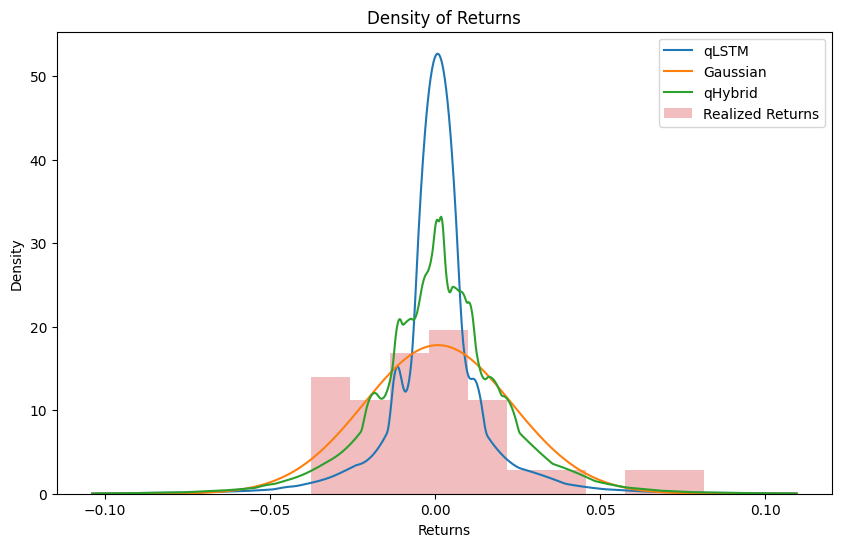

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(sample_grid, sample_pdf, label="qLSTM")
plt.plot(sample_grid, sample_gaussian_pdf, label="Gaussian")
plt.plot(sample_grid, sample_hybrid_pdf, label="qHybrid")
plt.hist(sample_return, bins=10, density=True, alpha=0.3, label="Realized Returns")
plt.xlabel("Returns")
plt.ylabel("Density")
plt.legend()
plt.title("Density of Returns")
plt.show()

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

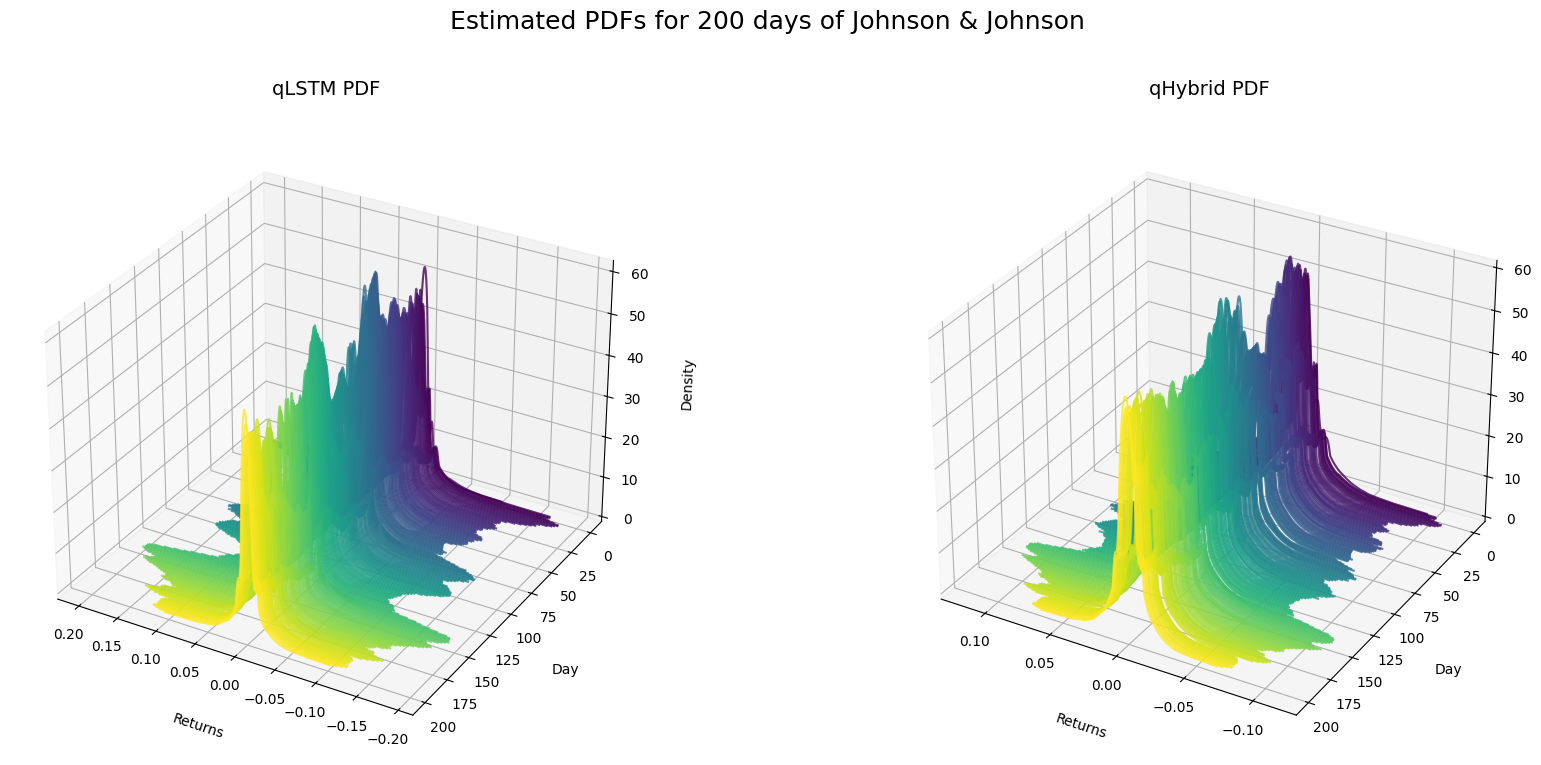

In [66]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors
from scipy.stats import norm  # Assuming norm.ppf is imported from scipy.stats

# Create the figure and two 3D axes
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(121, projection='3d')  # Left plot for original PDF
ax2 = fig.add_subplot(122, projection='3d')  # Right plot for hybrid PDF

# Number of curves to plot
num_curves = 200

# Add a colormap to differentiate the curves by quantile index
cmap = cm.get_cmap("viridis", num_curves)
norm_colors = colors.Normalize(vmin=0, vmax=num_curves)  # Normalize for color mapping

# Plot for the original PDF
for i in range(num_curves):
    sub_quants = test_values["s&p 500"]["all_pred_quantiles"][-i]
    sub_grid, sub_pdf, _ = generate_smooth_pdf(sub_quants, np.array(taus), **best_lstm_pdf_params)

    ax1.plot(
        sub_grid,
        sub_pdf,
        zs=i,
        zdir='y',
        color=cmap(norm_colors(i)),
        linewidth=1.5,
        alpha=0.8
    )

# Plot for the hybrid PDF
for i in range(num_curves):
    sub_quants = test_values["s&p 500"]["all_pred_quantiles"][-i]
    sub_mean = np.mean(test_values["s&p 500"]["observed_returns"][-i])
    sub_std = np.std(test_values["s&p 500"]["observed_returns"][-i])
    sub_base_quantiles = norm.ppf(np.array(taus), loc=sub_mean, scale=sub_std)
    sub_hybrid_quantiles = (sub_quants + sub_base_quantiles) / 2
    sub_hybrid_grid, sub_hybrid_pdf, _ = generate_smooth_pdf(sub_hybrid_quantiles, np.array(taus), **best_hybrid_pdf_params)

    ax2.plot(
        sub_hybrid_grid,
        sub_hybrid_pdf,
        zs=i,
        zdir='y',
        color=cmap(norm_colors(i)),
        linewidth=1.5,
        alpha=0.8
    )

# Customize the first plot (Original PDF)
ax1.set_xlabel('Returns', labelpad=15)
ax1.set_ylabel('Day', labelpad=15)
ax1.set_zlabel('Density', labelpad=15)
ax1.set_title("qLSTM PDF", fontsize=14, pad=20)
ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax1.view_init(elev=30, azim=120)

# Customize the second plot (Hybrid PDF)
ax2.set_xlabel('Returns', labelpad=15)
ax2.set_ylabel('Day', labelpad=15)
ax2.set_zlabel('Density', labelpad=15)
ax2.set_title("qHybrid PDF", fontsize=14, pad=20)
ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax2.view_init(elev=30, azim=120)

# Add an overarching title for the figure
fig.suptitle(f"Estimated PDFs for {num_curves} days of Johnson & Johnson", fontsize=18, y=0.95)

# Adjust layout and show the plots
plt.tight_layout(rect=[0, 0, 1, 0.93])  # Reserve space for the suptitle
plt.show()
